In [2]:
from dotenv import load_dotenv
import sys

sys.path.append("../../common")
load_dotenv()

True

In [3]:
import os
from langsmith_tracker import set_tracking
from langchain_print import stream_response
from multimodal import MultiModal
from tools_news import GoogleNews

# 인스턴스를 생성할 때 필요한 매개변수를 전달합니다.
set_tracking(project_name="17.LangGraph")

Langsmith 추적이 활성화되었습니다. [프로젝트명: 17.LangGraph]


### LangGraph 활용 Agent 구축

도구를 통해 챗봇에 웹검색을 수행하는 Agent를 구축해봅니다. function_calling 형태로 도구를 호출합니다.  

LangGraph와 Agent 를 함께 사용하면 Agent의 자유분방합을 제어하고 Controlvility를 높일 수 있습니다.  
  
LLM에 도구를 바인딩하여 입력된 요청에 따라 필요시 도구를 후출하는 Agent를 구축합니다.  
  
조건부 엣지를 통해 도구 호출 여부에 따라 다른 노드로 라우팅하는 방법입니다.


#### 도구(Tools) 사용하기

웹검색 도구를 예시로 구성합니다.  
  
웹검색 도구를 생성하기 위해 Tavily api 를 활용합니다. 


In [4]:
from tools_tavily import TavilySearch

tool = TavilySearch(max_results=3)

tools = [tool]

print(tool.invoke("비트코인 ETF 성적"))

[{'title': '비트코인 Etf 초라한 성적표…현물보다 손실폭 더 커 | 한국경제', 'url': 'https://www.hankyung.com/article/2022101214601', 'content': "비트코인 ETF '초라한 성적표'…현물보다 손실폭 더 커, 프로셰어스 전략ETF 70% 폭락 같은 기간 비트코인보다 더 하락 CME 선물가 추종, 실가격과 차이", 'score': 0.9976495, 'raw_content': '검색\n\n\n                                금융\n                            \n\n\n\n\t\t\t\t\t\t비트코인 ETF \'초라한 성적표\'…현물보다 손실폭 더 커\n                        \n\n\n\n                                                암호화폐 투자 뉴스레터 \'코알라\' 무료구독하세요\n                                            \n\n\n\n                                                트론, 도미니카 연방과 협력…"국가 블록체인 인프라 개발"\n                                            \n\n\n\n                                                삼성화재 자녀보험 신상품 \'마이 슈퍼스타\' 호평\n                                            \n\n\n"가뜩이나 힘든데" 자영업자 패닉…\'대형 폭탄\' 또 터졌다\n\n\nJYP 걸그룹 美 멤버 탈퇴 선언…"극단 선택 시도하게 하는 K팝"\n\n\n"9조짜리 수출계약 날아갈 판"…비상계엄 유탄 맞은 \'K-방산\'\n\n\n\'오빠 기다릴게요\'…쉴 새 없이 울리는 휴대폰에 \'공포\'\n\n\n\'코스피 구출 작전\'…연기금이 쓸어 담은 종목 봤더니\n\

상태를 정의합니다.  
LLM에 `bind_tools` 메서드를 통해 도구를 바인딩합니다.

In [5]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages


# State 정의
class State(TypedDict):
    messages: Annotated[list, add_messages]

In [6]:
from langchain_openai import ChatOpenAI

# LLM 초기화
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

# LLM 에 도구 바인딩
llm_with_tools = llm.bind_tools(tools)

노드를 정의합니다.

In [7]:
# 노드 함수 정의
def chatbot(state: State):
    answer = llm_with_tools.invoke(state["messages"])
    # 메세지 목록 반환
    return {"messages": [answer]}

그래프 생성 및 노드를 추가합니다.

In [8]:
from langgraph.graph import StateGraph

# 상태 그래프 초기화
graph_builder = StateGraph(State)

# 노드 추가
graph_builder.add_node(chatbot)

#### 도구 노드(Tool Node)

도구가 호출될 경우 실제로 실행할 수 있는 함수를 만들어야 합니다. 이를 위해 새로운 노드에 도구를 추가합니다.  
  
가장 최근의 메시지를 확인하고 메시지에 tool_calls가 포함되어 있으면 도구를 필요로 하는 질의라고 판단하여 도구를 사용할 수 있게 해야합니다.   
  
그렇기 때문에 도구를 호출하는 BasicToolNode를 구현합니다.  
  
지금은 직접 구현하지만, 나중에는 LangGraph의 pre-built 되어있는 [ToolNode](https://langchain-ai.github.io/langgraph/reference/prebuilt/#langgraph.prebuilt.tool_node.ToolNode) 로 대체할 수 있습니다.  

In [9]:
import json
from langchain_core.messages import ToolMessage


class BasicToolNode:
    """Run tools requested in the last AIMessage node"""

    def __init__(self, tools: list) -> None:
        # 도구 리스트
        self.tools_list = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        # 메시지가 존재할 경우 가장 최근 메시지 1개 추출
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")

        # 도구 호출 결과
        outputs = []
        for (
            tool_call
        ) in message.tool_calls:  # 도구가 필요한 메세지는 tool_calls 가 존재
            # 가지고 있는 도구 중에서 도구 이름을 통해 도구 호출하고 도구의 args(검색쿼리)를 통해 검색 결과를 받음
            tool_result = self.tools_list[tool_call["name"]].invoke(tool_call["args"])

            # return messges는 ToolMessage 형태로 반환, 이 안에는 도구 호출 결과, 도구 이름, 콜 아이디가 포함되어 반환
            outputs.append(
                # 도구 호출 결과를 메시지로 저장
                ToolMessage(
                    content=json.dumps(
                        tool_result, ensure_ascii=False
                    ),  # 도구 호출 결과를 문자열로 변환
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )

        return {"messages": outputs}


# 도구 노드 생성
tool_node = BasicToolNode(tools=[tool])

# 그래프에 도구 노드 추가
graph_builder.add_node("tools", tool_node)

#### 조건부 엣지(Conditional Edge)

도구 노드가 추가되면 `conditional_edges`를 정의할 수 있습니다.  
  
Edges는 한 노드에서 다음 노드로 제어 흐름을 라우팅합니다. 분기할때 사용합니다.  
  
Conditional edges는 일반적으로 "if" 문을 포함하여 현재 그래프 상태에 따라 다른 노드로 라우팅합니다. 이러한 함수는 현재 그래프 state를 받아 다음에 호출할 Node 를 나타내는 문자열 또는 문자열 목록 을 반환합니다.  
  
아래에서는 route_tools라는 라우터 함수를 정의하여 챗봇의 출력에서 tool_calls를 확인합니다.  
  
이 함수를 add_conditional_edges를 호출하여 그래프에 제공하면, chatbot 노드가 완료될 때마다 이 함수를 확인하여 다음으로 어디로 갈지 결정합니다.  
  
조건은 도구 호출이 있으면 tools로, 없으면 END로 라우팅됩니다.  
  
**참고**
- langgraph 에 pre-built 되어 있는 tools_condition 으로 대체할 수 있습니다.

--- 
  
`add_conditional_edges` 메서드는 시작 노드에서 여러 대상 노드로의 조건부 엣지를 추가합니다.  
  
**매개변수**  
  
- source (str): 시작 노드. 이 노드를 나갈 때 조건부 엣지가 실행됩니다.
- path (Union[Callable, Runnable]): 다음 노드를 결정하는 호출 가능한 객체 또는 Runnable. path_map을 지정하지 않으면 하나 이상의 노드를 반환해야 합니다. END를 반환하면 그래프 실행이 중지됩니다.
- path_map (Optional[Union[dict[Hashable, str], list[str]]]): 경로와 노드 이름 간의 매핑. 생략하면 path가 반환하는 값이 노드 이름이어야 합니다.
- then (Optional[str]): path로 선택된 노드 실행 후 실행할 노드의 이름.
  

**반환값**

- Self: 메서드 체이닝을 위해 자기 자신을 반환합니다.
  
**주요 기능**  
 
- 조건부 엣지를 그래프에 추가합니다.
- path_map을 딕셔너리로 변환합니다.
- path 함수의 반환 타입을 분석하여 자동으로 path_map을 생성할 수 있습니다.
- 조건부 분기를 그래프에 저장합니다.
  
**참고**  

- 이미 컴파일된 그래프에 엣지를 추가하면 경고 메시지가 출력됩니다.
- path 함수의 반환 값에 대한 타입 힌트가 없거나 path_map이 제공되지 않으면, 그래프 시각화 시 해당 엣지가 그래프의 모든 노드로 전환될 수 있다고 가정합니다.
- 동일한 이름의 분기가 이미 존재하는 경우 ValueError가 발생합니다.


In [10]:
from langgraph.graph import START, END


def route_tools(
    state: State,
):
    if messages := state.get("messages", []):
        # 가장 최근 AI 메시지 추출
        ai_message = messages[-1]
    else:
        # 입력 상태에 메시지가 없는 경우 예외 발생
        raise ValueError(f"No messages found in input state to tool_edge: {state}")

    # AI 메시지에 도구 호출이 있는 경우 "tools" 반환
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        # 도구 호출이 있는 경우 "tools" 반환
        return "tools"
    # 도구 호출이 없는 경우 "END" 반환
    return END


# `tools_condition` 함수는 챗봇이 도구 사용을 요청하면 "tools"를 반환하고, 직접 응답이 가능한 경우 "END"를 반환
graph_builder.add_conditional_edges(
    source="chatbot",
    path=route_tools,
    # route_tools 의 반환값이 "tools" 인 경우 "tools" 노드로, 그렇지 않으면 END 노드로 라우팅
    path_map={"tools": "tools", END: END},
)

# tools > chatbot
graph_builder.add_edge("tools", "chatbot")

# START > chatbot
graph_builder.add_edge(START, "chatbot")

# 그래프 컴파일
graph = graph_builder.compile()

**조건부 엣지**가 단일 노드에서 시작해야 합니다.  
  
이는 그래프에 "chatbot" 노드가 실행될 때마다 도구를 호출하면 'tools'로 이동하고, 직접 응답하면 루프를 종료하라는 의미입니다.  
  
사전 구축된 tools_condition처럼, 함수는 도구 호출이 없을 경우 END 문자열을 반환(그래프 종료) 합니다. 그래프가 END로 전환되면 더 이상 완료할 작업이 없으며 실행을 중지합니다.  

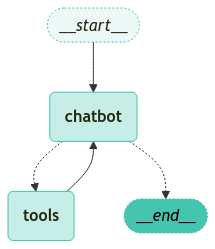

In [12]:
from graphs import visualize_graph

# 그래프 시각화
visualize_graph(graph)

질의합니다.

In [13]:
inputs = {"messages": "코인 종류에 대해 검색해 줘"}

for event in graph.stream(inputs, stream_mode="values"):
    for key, value in event.items():
        print(f"\n==============\nSTEP: {key}\n==============\n")
        # display_message_tree(value["messages"][-1])
        print(value[-1])


STEP: messages

content='코인 종류에 대해 검색해 줘' additional_kwargs={} response_metadata={} id='064787cf-e8a8-45a3-9fe8-facb4c475f09'

STEP: messages

content='' additional_kwargs={'tool_calls': [{'id': 'call_vM57Ciin02R3NujxVmXJwaob', 'function': {'arguments': '{"query":"코인 종류"}', 'name': 'tavily_web_search'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 100, 'total_tokens': 119, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_bba3c8e70b', 'finish_reason': 'tool_calls', 'logprobs': None} id='run-d00dcbd0-7cc7-4f5d-9324-bf7be97c8986-0' tool_calls=[{'name': 'tavily_web_search', 'args': {'query': '코인 종류'}, 'id': 'call_vM57Ciin02R3NujxVmXJwaob', 'type': 'tool_call'}] usage_metadata={'input_tokens': 100, 'o

![image.png](./image/langgraph-toolcalling-flow.png)